This notebook evaluates our model by:
1. Plotting training loss history
2. Visualizing sample completions (input/masked/output)
3. Calculating quantitative metrics (L1 and LPIPS)

In [ ]:
#### SECTION 1: IMPORTS & SETUP ####
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import requests
import json
import random
import glob
import subprocess
from tqdm.notebook import tqdm
from PIL import Image, ImageOps
import cv2

print("Installing required libraries...")
!pip install datasets lpips -q  # Install Hugging Face datasets and LPIPS
from datasets import load_dataset
import lpips

if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Set seeds
SEED = 42 # ones with good examples to use: 42, 456, 22, 11, 33, 44, 55
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"PyTorch Version: {torch.__version__}")
try:
    import datasets
    print(f"Datasets Library Version: {datasets.__version__}")
except ImportError:
    print("WARNING: Hugging Face datasets library not found. Installing...")
    subprocess.run(['pip', 'install', 'datasets'], check=True, capture_output=True)
    import datasets
    print(f"Datasets Library Version: {datasets.__version__}")

print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")

Installing required libraries...
PyTorch Version: 2.6.0+cu124
Datasets Library Version: 3.5.1
CUDA Available: True
CUDA Device Name: NVIDIA A100-SXM4-40GB


In [ ]:
#### SECTION 2: CONFIGURATION ####
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- Model & Training Parameters ---
IMAGE_SIZE = 128
IN_CHANNELS = 1
OUT_CHANNELS = 1
FEATURES_G = 48

# --- Checkpoint Information ---
CHECKPOINT_FILENAME = "checkpoint_epoch_030.pth"
CHECKPOINT_PATH = os.path.join("/content/", CHECKPOINT_FILENAME)

# --- Data Parameters ---
# QuickDraw
QUICKDRAW_CATEGORIES_TRAINED = ['cat', 'dog', 'house', 'tree', 'bicycle', 'car', 'face', 'flower']
QUICKDRAW_DATA_DIR = './data/quickdraw_eval'
SAMPLES_PER_CATEGORY_QD_TRAIN = 5000
SAMPLES_PER_CATEGORY_QD_EVAL = 200

# ImageNet-Sketch
IMAGENET_HF_DATASET_NAME = "imagenet_sketch"
NUM_IMAGENET_SAMPLES_EVAL = 500
NUM_SAMPLES_TO_SHOW_INET = 8

# --- Evaluation Parameters ---
MASK_MODE = 'line_aware'  # Or 'random'
MASK_SQUARE_SIZE = IMAGE_SIZE // 4 ### usually we do // 4, can try smaller/bigger for a few runs
EVAL_BATCH_SIZE = 32

# --- Visualization Parameters ---
NUM_SAMPLES_TO_SHOW_QD = 10
FIGSIZE_PER_SAMPLE = 3

Using device: cuda


In [ ]:
#### SECTION 3: HELPER FUNCTIONS ####

def download_quickdraw_dataset(categories, save_dir):
    """Download QuickDraw dataset files if not already present."""
    os.makedirs(save_dir, exist_ok=True)
    base_url = "https://storage.googleapis.com/quickdraw_dataset/full/simplified/"
    print(f"QuickDraw download check/run to {save_dir}...")

    all_exist = True
    for category in categories:
        file_path = os.path.join(save_dir, f"{category}.ndjson")
        if not os.path.exists(file_path):
            all_exist = False
            break

    if all_exist:
        print("All needed QuickDraw files already exist.")
        return

    # Download missing files
    for category in tqdm(categories, desc="Checking/Downloading QD"):
        url = f"{base_url}{category.replace(' ', '%20')}.ndjson"
        file_path = os.path.join(save_dir, f"{category}.ndjson")
        if os.path.exists(file_path):
            continue

        try:
            print(f"Downloading {category}...")
            response = requests.get(url, stream=True)
            response.raise_for_status()
            with open(file_path, 'wb') as f:
                for chunk in response.iter_content(8192):
                    f.write(chunk)
            print(f" Success: {category}")
        except Exception as e:
            print(f" Fail/Error {category}: {e}")

        # Remove empty files
        if os.path.exists(file_path) and not os.path.getsize(file_path) > 0:
            os.remove(file_path)

    print("QuickDraw download check finished.")


def preprocess_imagenet_sketch_hf(image_pil, target_size=128, threshold=None, debug=False):
    """Preprocesses ImageNet-Sketch PIL image from Hugging Face dataset."""
    try:
        # Image is already PIL, convert to grayscale if needed
        img = image_pil.convert('L') if image_pil.mode != 'L' else image_pil
        if debug:
            print(f"  Initial min/max: {np.min(np.array(img))}/{np.max(np.array(img))}")

        # Invert colors
        img = ImageOps.invert(img)
        img_np_inverted = np.array(img)
        if debug:
            print(f"  After invert min/max: {np.min(img_np_inverted)}/{np.max(img_np_inverted)}")

        # Resize
        img = img.resize((target_size, target_size), Image.LANCZOS)
        img_np_resized = np.array(img)
        if debug:
            print(f"  After resize min/max: {np.min(img_np_resized)}/{np.max(img_np_resized)}")

        img_np = img_np_resized
        if threshold is not None:
            print(f"  Applying threshold: {threshold}")
            _, img_np = cv2.threshold(img_np, threshold, 255, cv2.THRESH_BINARY)
            if debug:
                print(f"  After threshold min/max: {np.min(img_np)}/{np.max(img_np)}")

        # Convert back to PIL for ToTensor
        img_pil_final = Image.fromarray(img_np)

        # Apply ToTensor transform (scales to [0, 1])
        transform_to_tensor = transforms.ToTensor()
        img_tensor = transform_to_tensor(img_pil_final)
        if debug:
            print(f"  Final tensor min/max: {img_tensor.min():.2f}/{img_tensor.max():.2f}, shape: {img_tensor.shape}")

        if img_tensor.max() == 0.0:
            print("  WARNING: Preprocessed tensor is all black")

        return img_tensor # Shape: [1, H, W]

    except Exception as e:
        print(f"Error preprocessing ImageNet-Sketch sample: {e}")
        return None

def evaluate_custom_sketches(generator, device, mask_square_size=32, num_to_show=10, figsize_per_sample=3):
    """Evaluates model on custom sketches in 'custom_sketches' directory."""
    print("\n--- Evaluating on Custom Sketches ---")

    custom_dir = "./custom_sketches"
    if not os.path.exists(custom_dir):
        os.makedirs(custom_dir)
        print(f"Created '{custom_dir}' directory. Please add your sketches there and run again.")
        return

    # Find all image files in the directory
    valid_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.gif']
    custom_files = []
    for ext in valid_extensions:
        custom_files.extend(glob.glob(os.path.join(custom_dir, f"*{ext}")))

    if not custom_files:
        print(f"No image files found in '{custom_dir}'. Please add some sketches and run again.")
        return

    print(f"Found {len(custom_files)} custom sketches in '{custom_dir}'.")

    originals, masked_inputs, outputs, masks = [], [], [], []

    # Process each file
    for file_path in custom_files:
        try:
            img = Image.open(file_path).convert('L')

            img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.LANCZOS)

            img = ImageOps.invert(img)

            to_tensor = transforms.ToTensor()
            original_tensor = to_tensor(img)

            partial_tensor, mask_tensor = apply_manual_mask(original_tensor, mask_square_size, device)

            # Generate completion
            with torch.no_grad():
                output_tensor = generator(partial_tensor.unsqueeze(0).to(device)).squeeze(0)

            # Store results
            originals.append(original_tensor)
            masked_inputs.append(partial_tensor.cpu())
            outputs.append(output_tensor.cpu())
            masks.append(mask_tensor.cpu())

        except Exception as e:
            print(f"Error processing file {os.path.basename(file_path)}: {e}")

    if originals:
        display_results_with_highlighted_target(
            masked_inputs,
            outputs,
            originals,
            masks,
            num_to_show=min(num_to_show, len(originals)),
            figsize_per_sample=figsize_per_sample,
            title="Custom Sketch Completions"
        )
    else:
        print("No custom sketches were successfully processed.")

def apply_manual_mask(image_tensor, mask_square_size, device):
    """Applies a square mask fully contained within the image bounds."""
    c, h, w = image_tensor.shape

    # Make sure mask size isn't larger than the image with margins
    safe_margin = 2
    mask_size = min(mask_square_size, h - 2*safe_margin, w - 2*safe_margin)
    if mask_size < 8:  # For very small images
        mask_size = min(h // 2, w // 2)

    # Create mask (1 = keep, 0 = remove)
    keep_value = torch.ones((), device=image_tensor.device)
    remove_value = torch.zeros((), device=image_tensor.device)
    mask_keep = torch.full_like(image_tensor, keep_value)

    # Calculate valid range for mask placement
    if h > mask_size + 2*safe_margin and w > mask_size + 2*safe_margin:
        y1 = random.randint(safe_margin, h - mask_size - safe_margin)
        x1 = random.randint(safe_margin, w - mask_size - safe_margin)
        mask_keep[:, y1:y1+mask_size, x1:x1+mask_size] = remove_value
    else:
        # For very small images, center the mask
        y1 = max(0, (h - mask_size) // 2)
        x1 = max(0, (w - mask_size) // 2)
        mask_h = min(mask_size, h)
        mask_w = min(mask_size, w)
        mask_keep[:, y1:y1+mask_h, x1:x1+mask_w] = remove_value

    partial_image = image_tensor.to(device) * mask_keep.to(device)
    display_mask = 1.0 - mask_keep  # For visualization of mask/red highlighting (1 = masked area)

    return partial_image, display_mask


def run_inference(generator_model, batch_input_tensor, device):
    """Runs the generator on a batch of input tensors."""
    generator_model.eval()
    with torch.no_grad():
        output = generator_model(batch_input_tensor.to(device))
        return output


def display_results(input_list_or_batch, output_list_or_batch, target_list_or_batch=None,
                   is_masks=None, num_to_show=5, figsize_per_sample=3, title="Completions"):
    """Displays batches or lists of input/output/(optional)target tensors."""
    num_available = 0
    input_batch = None
    output_batch = None
    target_batch = None
    mask_batch = None

    # Determine input type and create tensor batches if necessary
    if isinstance(input_list_or_batch, torch.Tensor):
        input_batch = input_list_or_batch
        output_batch = output_list_or_batch
        target_batch = target_list_or_batch if target_list_or_batch is not None else None
        mask_batch = is_masks if is_masks is not None else None
        num_available = input_batch.size(0)
    elif isinstance(input_list_or_batch, list):
        input_list = input_list_or_batch
        output_list = output_list_or_batch
        target_list = target_list_or_batch if target_list_or_batch is not None else None
        mask_list = is_masks if is_masks is not None else None
        num_available = len(input_list) if input_list else 0

        if num_available > 0:
            try:
                # Stack lists into batch tensors
                input_batch = torch.stack(input_list)
                output_batch = torch.stack(output_list)
                if target_list:
                    target_batch = torch.stack(target_list)
                if mask_list:
                    mask_batch = torch.stack(mask_list)
            except Exception as e:
                print(f"Error stacking lists into tensors: {e}")
                return
    else:
        print("Error: Invalid input type for display_results.")
        return

    num_samples = min(num_to_show, num_available)
    if num_samples == 0 or input_batch is None or output_batch is None:
        print("No samples or necessary tensors available to display.")
        return

    has_target = target_batch is not None
    num_cols = 3 if has_target else 2
    col_titles = ['Input (Masked)', 'Generated Output', 'Target/Original'] if has_target else ['Input (Masked)', 'Generated Output']

    fig, axes = plt.subplots(num_samples, num_cols, figsize=(num_cols * figsize_per_sample, num_samples * figsize_per_sample + 0.5))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)
    fig.suptitle(title, fontsize=14, y=0.99)

    for i in range(num_samples):
        inp = input_batch[i].cpu().squeeze().numpy()
        outp = output_batch[i].cpu().squeeze().numpy()
        mask = mask_batch[i].cpu().squeeze().numpy() if mask_batch is not None else None
        ax_row = axes[i]

        # Plot masked input
        ax_row[0].imshow(inp, cmap='gray', vmin=0, vmax=1)
        if mask is not None:
            # Add mask overlay
            overlay = np.zeros((*mask.shape, 4))  # RGBA
            overlay[..., 0] = 1.0  # Red
            overlay[..., 3] = mask * 0.3  # Alpha
            ax_row[0].imshow(overlay)
        ax_row[0].set_title(col_titles[0])
        ax_row[0].axis('off')

        # Plot generated output
        ax_row[1].imshow(outp, cmap='gray', vmin=0, vmax=1)
        ax_row[1].set_title(col_titles[1])
        ax_row[1].axis('off')

        # Plot original/target if available
        if has_target:
            tgt = target_batch[i].cpu().squeeze().numpy()
            ax_row[2].imshow(tgt, cmap='gray', vmin=0, vmax=1)
            ax_row[2].set_title(col_titles[2])
            ax_row[2].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

def display_results_with_highlighted_target(input_list_or_batch, output_list_or_batch, target_list_or_batch,
                                           mask_list_or_batch, num_to_show=5, figsize_per_sample=3,
                                           title="Completions"):
    """
    Displays sketch completion results with mask boundary highlighted on the target/original image.

    Parameters:
        input_list_or_batch: Partial images (with masked regions removed)
        output_list_or_batch: Generated completions from the model
        target_list_or_batch: Original complete images
        mask_list_or_batch: Masks (1.0 in masked regions)
        num_to_show: Maximum number of samples to display
        figsize_per_sample: Size of each image in the grid
        title: Plot title
    """
    # Process inputs to ensure we have tensors
    if isinstance(input_list_or_batch, list):
        input_batch = torch.stack(input_list_or_batch)
        output_batch = torch.stack(output_list_or_batch)
        target_batch = torch.stack(target_list_or_batch)
        mask_batch = torch.stack(mask_list_or_batch)
    else:
        input_batch = input_list_or_batch
        output_batch = output_list_or_batch
        target_batch = target_list_or_batch
        mask_batch = mask_list_or_batch

    num_samples = min(num_to_show, input_batch.size(0))
    if num_samples == 0:
        print("No samples available to display.")
        return

    # Create figure and axes
    fig, axes = plt.subplots(num_samples, 3, figsize=(3 * figsize_per_sample, num_samples * figsize_per_sample + 0.5))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)
    fig.suptitle(title, fontsize=14, y=0.99)

    # Column titles
    col_titles = ['Input (Masked)', 'Generated Output', 'Target/Original (Mask Highlighted)']

    # Display each row of samples
    for i in range(num_samples):
        inp = input_batch[i].cpu().squeeze().numpy()
        outp = output_batch[i].cpu().squeeze().numpy()
        tgt = target_batch[i].cpu().squeeze().numpy()
        mask = mask_batch[i].cpu().squeeze().numpy()

        axes[i, 0].imshow(inp, cmap='gray', vmin=0, vmax=1)
        axes[i, 0].set_title(col_titles[0])
        axes[i, 0].axis('off')

        axes[i, 1].imshow(outp, cmap='gray', vmin=0, vmax=1)
        axes[i, 1].set_title(col_titles[1])
        axes[i, 1].axis('off')

        # Display target/original with highlighted mask border (third column)
        tgt_rgb = np.stack([tgt, tgt, tgt], axis=2)

        # Create mask border using morphological operations
        # Dilate then erode to find the boundary
        kernel = np.ones((3, 3), np.uint8)
        mask_dilated = cv2.dilate(mask.astype(np.uint8), kernel, iterations=1)
        mask_eroded = cv2.erode(mask.astype(np.uint8), kernel, iterations=1)
        mask_border = mask_dilated - mask_eroded

        # Add bright red border around the mask on the target image
        tgt_rgb[mask_border > 0, 0] = 1.0  # Red channel
        tgt_rgb[mask_border > 0, 1] = 0.0  # Green channel
        tgt_rgb[mask_border > 0, 2] = 0.0  # Blue channel

        # Display the highlighted target
        axes[i, 2].imshow(tgt_rgb)
        axes[i, 2].set_title(col_titles[2])
        axes[i, 2].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


def plot_final_losses(g_losses, d_losses, g_adv_losses, g_l1_masked_losses,
                      g_perceptual_losses, d_gp_losses, wasserstein_distances,
                      mask_weight, perceptual_weight, lambda_gp, num_epochs_trained,
                      save_path="final_losses_plot.png"):
    """Plot training losses loaded from checkpoint."""
    if not g_losses or not d_losses:
        print("No loss history provided.")
        return

    epochs = range(1, num_epochs_trained + 1)
    print(f"Plotting losses for {num_epochs_trained} epochs...")

    plt.figure(figsize=(14, 10))
    plt.suptitle(f'Training Losses up to Epoch {num_epochs_trained}', fontsize=16)

    # Overall losses
    plt.subplot(2, 2, 1)
    plt.plot(epochs, g_losses, label='G Total', c='b')
    plt.plot(epochs, d_losses, label='D Total', c='r')
    plt.title('Overall Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Generator loss components (weighted)
    plt.subplot(2, 2, 2)
    plt.plot(epochs, g_adv_losses, label='G Adv [-D(G(z))]', c='g', ls='-')
    plt.plot(epochs, [l*mask_weight for l in g_l1_masked_losses],
             label=f'G L1 Mask (w={mask_weight})', c='orange', ls='--')
    if perceptual_weight > 0 and g_perceptual_losses:
        plt.plot(epochs, [l*perceptual_weight for l in g_perceptual_losses],
                 label=f'G Perc (w={perceptual_weight})', c='cyan', ls='-.')
    plt.title('G Loss Components (Weighted)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Critic loss components
    plt.subplot(2, 2, 3)
    plt.plot(epochs, wasserstein_distances, label='W-Dist Est', c='purple', ls='-')
    plt.plot(epochs, [l*lambda_gp for l in d_gp_losses],
             label=f'Grad Pen (Term*{lambda_gp})', c='brown', ls='--')
    plt.title('Critic Loss Components')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

    # Generator loss components (unweighted)
    plt.subplot(2, 2, 4)
    plt.plot(epochs, g_adv_losses, label='G Adv', c='g', ls='-')
    plt.plot(epochs, g_l1_masked_losses, label='G L1 Mask', c='orange', ls='--')
    if perceptual_weight > 0 and g_perceptual_losses:
        plt.plot(epochs, g_perceptual_losses, label='G Perc', c='cyan', ls='-.')
    plt.title('G Loss Components (Unweighted)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(save_path)
    print(f"Loss plot saved to {save_path}")
    plt.show()


def calculate_metrics(generator_model, dataloader, lpips_model, device, dataset_name="Dataset"):
    """Calculate L1 and LPIPS metrics for a dataset."""
    if generator_model is None:
        print(f"Skipping metrics for {dataset_name}: Generator model missing.")
        return None, None

    generator_model.eval()

    # Define L1 loss for masked area calculation
    l1_loss_fn = nn.L1Loss(reduction='sum')

    total_masked_l1 = 0.0
    total_lpips = 0.0
    num_samples = 0
    processed_batches = 0

    use_lpips = lpips_model is not None
    if use_lpips:
        lpips_model.eval()
    else:
        print(f"Warning: LPIPS model not available for {dataset_name}.")

    print(f"Calculating metrics for {dataset_name}...")
    progress_bar = tqdm(dataloader, desc=f"Metrics on {dataset_name}", leave=False)

    batch_l1_sums = []
    batch_mask_pixels = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(progress_bar):
            # Skip invalid batches
            if batch.get('complete') is None or (batch['complete'] == -99.0).all():
                print(f"Warning: Skipping batch {batch_idx} due to dummy data.")
                continue

            if not isinstance(batch.get('partial'), torch.Tensor) or not isinstance(batch.get('mask'), torch.Tensor):
                print(f"Warning: Skipping batch {batch_idx} - non-tensor data.")
                continue

            targets = batch['complete'].to(device)
            partial = batch['partial'].to(device)
            masks = batch['mask'].to(device)

            outputs = generator_model(partial)

            masked_outputs = outputs * masks
            masked_targets = targets * masks
            batch_masked_l1_sum = l1_loss_fn(masked_outputs, masked_targets)

            num_masked_pixels = masks.sum().item()
            batch_l1_sums.append(batch_masked_l1_sum.item())
            batch_mask_pixels.append(num_masked_pixels)

            avg_batch_masked_l1 = (batch_masked_l1_sum / num_masked_pixels) if num_masked_pixels > 0 else 0
            total_masked_l1 += avg_batch_masked_l1.item()

            # Calculate LPIPS if available
            batch_lpips_val = 0
            if use_lpips:
                try:
                    # LPIPS expects RGB and values in [-1, 1]
                    lpips_outputs_norm = (outputs * 2 - 1).repeat(1, 3, 1, 1)
                    lpips_targets_norm = (targets * 2 - 1).repeat(1, 3, 1, 1)
                    batch_lpips = lpips_model(lpips_outputs_norm, lpips_targets_norm)
                    total_lpips += batch_lpips.sum().item()
                    batch_lpips_val = batch_lpips.mean().item()
                except Exception as e:
                    print(f"Warning: LPIPS failed for batch {batch_idx}: {e}")

            num_samples += targets.size(0)
            processed_batches += 1

            # Update progress bar
            progress_bar.set_postfix({
                'MaskL1(batch)': f"{avg_batch_masked_l1:.5f}",
                'LPIPS(batch_avg)': f"{batch_lpips_val:.4f}"
            })

    if "ImageNet" in dataset_name:
        print(f"\nDebug Info for {dataset_name} Masked L1:")
        print(f"  Raw L1 Sums (first 10 batches): {batch_l1_sums[:10]}")
        print(f"  Mask Pixel Counts (first 10 batches): {batch_mask_pixels[:10]}")
        non_zero_sums = [s for s in batch_l1_sums if s > 1e-9]
        print(f"  Number batches non-zero L1 (>1e-9): {len(non_zero_sums)}/{processed_batches}")
        if non_zero_sums:
            print(f"  Avg non-zero L1 sum: {np.mean(non_zero_sums):.4f}")

    avg_masked_l1 = total_masked_l1 / processed_batches if processed_batches > 0 else 0
    avg_lpips = total_lpips / num_samples if num_samples > 0 and use_lpips else None

    print(f"Metrics for {dataset_name} ({num_samples} samples / {processed_batches} batches):")
    print(f"  Average Masked L1 (per pixel): {avg_masked_l1:.6f}")
    if avg_lpips is not None:
        print(f"  Average LPIPS: {avg_lpips:.4f}")
    else:
        print("  LPIPS not calculated or failed.")

    return avg_masked_l1, avg_lpips

In [ ]:
#### SECTION 4: DATASET CLASS ####

class SketchDataset(Dataset):
    """Dataset class for QuickDraw sketches with masking."""
    def __init__(self, data_dir, categories, image_size=128, transform=None,
                 max_samples_per_category=1000, mask_mode='random', mask_square_size=32,
                 skip_first_n=0):
        self.data_dir = data_dir
        self.categories = categories
        self.image_size = image_size
        self.transform = transform
        self.max_samples = max_samples_per_category
        self.mask_mode = mask_mode
        self.mask_square_size = mask_square_size
        self.skip_first_n = skip_first_n
        self.sketches = []
        self.labels = []

        mode = "Unseen" if skip_first_n > 0 else "Seen/All"
        print(f"Loading QuickDraw dataset ({mode} samples)...")
        self._load_data()
        print(f"QuickDraw {mode} dataset loaded with {len(self.sketches)} samples.")

    def _load_data(self):
        total_loaded = 0
        # Calculate a rough global limit to prevent loading huge amounts if max_samples is large
        max_total_samples = self.max_samples * len(self.categories)

        for i, category in enumerate(self.categories):
            file_path = os.path.join(self.data_dir, f"{category}.ndjson")
            if not os.path.exists(file_path):
                print(f"Warning: File not found for category '{category}', skipping.")
                continue

            lines_processed = 0
            count_per_cat = 0
            try:
                with open(file_path, 'r') as f:
                    for line in tqdm(f, desc=f"Loading '{category}' (Skip={self.skip_first_n})", leave=False):
                        lines_processed += 1

                        # Skip the first N lines (part of the training data)
                        # allows us to specifically make completions of sketches
                        # that were not in our training data to test
                        # generalization
                        if lines_processed <= self.skip_first_n:
                            continue

                        if total_loaded >= max_total_samples:
                            break
                        if count_per_cat >= self.max_samples:
                            break

                        try:
                            data = json.loads(line)
                            if data.get('recognized', False):
                                self.sketches.append(data['drawing'])
                                self.labels.append(i)
                                count_per_cat += 1
                                total_loaded += 1
                        except (json.JSONDecodeError, KeyError):
                            pass

                if total_loaded >= max_total_samples:
                    break
            except Exception as e:
                print(f"Error reading file {file_path}: {e}")

    def _sketch_to_image(self, drawing_strokes):
        image = np.zeros((self.image_size, self.image_size), dtype=np.uint8)
        for stroke in drawing_strokes:
            xs, ys = stroke[0], stroke[1]
            xs = np.clip(np.array(xs) * (self.image_size - 1) / 255.0, 0, self.image_size - 1)
            ys = np.clip(np.array(ys) * (self.image_size - 1) / 255.0, 0, self.image_size - 1)
            for i in range(len(xs) - 1):
                x1, y1 = int(round(xs[i])), int(round(ys[i]))
                x2, y2 = int(round(xs[i+1])), int(round(ys[i+1]))
                cv2.line(image, (x1, y1), (x2, y2), color=255, thickness=1)
        return image

    def _create_mask(self, complete_img_np):
        mask = np.zeros_like(complete_img_np, dtype=np.float32)
        h, w = complete_img_np.shape
        current_mask_mode = self.mask_mode
        y1, y2, x1, x2 = 0, h, 0, w

        # Ensure mask is not larger than image
        mask_size = min(self.mask_square_size, h - 4, w - 4)
        if mask_size < 8:  # If image is small, default to smaller mask
            mask_size = min(h // 2, w // 2)

        if self.mask_mode == 'line_aware':
            # Calculate image gradients
            sobelx = cv2.Sobel(complete_img_np, cv2.CV_64F, 1, 0, ksize=5)
            sobely = cv2.Sobel(complete_img_np, cv2.CV_64F, 0, 1, ksize=5)
            gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)

            if gradient_magnitude.max() > 0:
                gradient_magnitude = (gradient_magnitude / gradient_magnitude.max()) * 255

            gradient_magnitude = gradient_magnitude.astype(np.uint8)
            threshold = 100
            high_grad_points = np.argwhere(gradient_magnitude > threshold)

            if len(high_grad_points) > 0:
                valid_points = []
                half_size = mask_size // 2
                padding = 2  # Extra safety padding

                for point in high_grad_points:
                    y, x = point
                    if (half_size + padding <= y < h - half_size - padding and
                        half_size + padding <= x < w - half_size - padding):
                        valid_points.append(point)

                # If we have valid points, use one; otherwise fall back to random
                if valid_points:
                    center_idx = random.choice(range(len(valid_points)))
                    center_y, center_x = valid_points[center_idx]

                    half_size = mask_size // 2
                    y1 = center_y - half_size
                    y2 = center_y + half_size + (mask_size % 2)
                    x1 = center_x - half_size
                    x2 = center_x + half_size + (mask_size % 2)
                else:
                    current_mask_mode = 'random'
            else:
                current_mask_mode = 'random'

        if current_mask_mode == 'random':
            # Place mask in a safe region away from edges
            safe_margin = 2
            max_y_start = h - mask_size - safe_margin
            max_x_start = w - mask_size - safe_margin

            if max_y_start > safe_margin and max_x_start > safe_margin:
                y1 = random.randint(safe_margin, max_y_start)
                x1 = random.randint(safe_margin, max_x_start)
                y2 = y1 + mask_size
                x2 = x1 + mask_size
            else:
                y1 = (h - mask_size) // 2
                x1 = (w - mask_size) // 2
                y2 = y1 + mask_size
                x2 = x1 + mask_size

        # Set mask region to 1.0 (masked area)
        mask[y1:y2, x1:x2] = 1.0
        return mask

    def __len__(self):
        return len(self.sketches)

    def __getitem__(self, idx):
        drawing = self.sketches[idx]

        complete_img_np = self._sketch_to_image(drawing)

        mask_np = self._create_mask(complete_img_np)

        partial_img_np = complete_img_np * (1 - mask_np)

        # Convert to PIL
        complete_img_pil = Image.fromarray(complete_img_np)
        partial_img_pil = Image.fromarray(partial_img_np.astype(np.uint8))

        if self.transform:
            complete_tensor = self.transform(complete_img_pil)
            partial_tensor = self.transform(partial_img_pil)
            mask_tensor = self.transform(Image.fromarray((mask_np * 255).astype(np.uint8)))
            mask_tensor = (mask_tensor > 0.5).float()
        else:
            to_tensor = transforms.ToTensor()
            complete_tensor = to_tensor(complete_img_pil)
            partial_tensor = to_tensor(partial_img_pil)
            mask_tensor = to_tensor(Image.fromarray((mask_np * 255).astype(np.uint8)))
            mask_tensor = (mask_tensor > 0.5).float()

        return {'complete': complete_tensor, 'partial': partial_tensor, 'mask': mask_tensor}


class ImageNetSketchEvalDataset(Dataset):
    """Dataset class for ImageNet-Sketch with masking."""
    def __init__(self, hf_dataset, mask_mode, mask_size, img_size, device, num_samples):
        self.hf_dataset = hf_dataset
        self.mask_mode = mask_mode
        self.mask_size = mask_size
        self.img_size = img_size
        self.device = device
        self.num_samples = num_samples
        self.error_count = 0

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        if idx >= len(self.hf_dataset):
            raise IndexError

        try:
            item = self.hf_dataset[idx]
            original_pil = item['image']

            original_tensor = preprocess_imagenet_sketch_hf(
                original_pil,
                target_size=self.img_size,
                threshold=None
            )

            if original_tensor is None:
                raise ValueError("Preprocessing failed")

            partial_tensor, display_mask = apply_manual_mask(
                original_tensor,
                self.mask_size,
                self.device
            )

            return {
                'complete': original_tensor,
                'partial': partial_tensor,
                'mask': display_mask
            }

        except Exception as e:
            self.error_count += 1
            dummy = torch.full((1, self.img_size, self.img_size), -99.0)
            return {
                'complete': dummy,
                'partial': dummy,
                'mask': dummy
            }

In [ ]:
#### SECTION 5: MODEL ARCHITECTURE ####

class SpatialAttention(nn.Module):
    """Spatial Attention module for the generator."""
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Generate attention map from average and max pooling
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        channel_reduced = torch.cat([avg_out, max_out], dim=1)

        attention_map = self.conv(channel_reduced)
        attention_map = self.sigmoid(attention_map)

        # Apply attention
        return x * attention_map


class SimpleSketchUNetWithAttention(nn.Module):
    """U-Net with Spatial Attention for sketch completion."""
    def __init__(self, in_channels=1, out_channels=1, features=64):
        super(SimpleSketchUNetWithAttention, self).__init__()

        # Encoder blocks
        self.enc1 = self._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(2, 2)
        self.enc2 = self._block(features, features*2, name="enc2")
        self.pool2 = nn.MaxPool2d(2, 2)
        self.enc3 = self._block(features*2, features*4, name="enc3")
        self.pool3 = nn.MaxPool2d(2, 2)
        self.enc4 = self._block(features*4, features*8, name="enc4")
        self.pool4 = nn.MaxPool2d(2, 2)

        # Bottleneck with attention
        self.bottleneck_conv = self._block(features*8, features*16, name="bottleneck")
        self.bottleneck_attn = SpatialAttention(kernel_size=7)

        # Decoder blocks
        self.upconv4 = nn.ConvTranspose2d(features*16, features*8, 2, 2)
        self.dec4 = self._block(features*16, features*8, name="dec4")

        self.upconv3 = nn.ConvTranspose2d(features*8, features*4, 2, 2)
        self.dec3 = self._block(features*8, features*4, name="dec3")

        self.upconv2 = nn.ConvTranspose2d(features*4, features*2, 2, 2)
        self.dec2 = self._block(features*4, features*2, name="dec2")

        self.upconv1 = nn.ConvTranspose2d(features*2, features, 2, 2)
        self.dec1 = self._block(features*2, features, name="dec1")

        # Final layer
        self.final_conv = nn.Conv2d(features, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

        print("Generator architecture (with Attention) defined.")

    def forward(self, x):
        # Encoder path
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        e3 = self.enc3(p2)
        p3 = self.pool3(e3)

        e4 = self.enc4(p3)
        p4 = self.pool4(e4)

        # Bottleneck with attention
        b_conv = self.bottleneck_conv(p4)
        b_attn = self.bottleneck_attn(b_conv)

        # Decoder path with skip connections
        d4 = self.upconv4(b_attn)
        cat4 = torch.cat((d4, e4), dim=1)
        dec4_out = self.dec4(cat4)

        d3 = self.upconv3(dec4_out)
        cat3 = torch.cat((d3, e3), dim=1)
        dec3_out = self.dec3(cat3)

        d2 = self.upconv2(dec3_out)
        cat2 = torch.cat((d2, e2), dim=1)
        dec2_out = self.dec2(cat2)

        d1 = self.upconv1(dec2_out)
        cat1 = torch.cat((d1, e1), dim=1)
        dec1_out = self.dec1(cat1)

        # Final convolution and activation
        output = self.final_conv(dec1_out)
        output = self.sigmoid(output)

        return output

    def _block(self, in_channels, features, name):
        """Creates a convolutional block with normalization and activation."""
        return nn.Sequential(
            nn.Conv2d(in_channels, features, 3, padding=1, bias=False),
            nn.InstanceNorm2d(features, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(features, features, 3, padding=1, bias=False),
            nn.InstanceNorm2d(features, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )

In [ ]:
#### SECTION 6: MODEL LOADING ####

def load_checkpoint(checkpoint_path, device):
    """Load model and losses from checkpoint file."""
    print(f"Loading checkpoint file: {checkpoint_path}")

    if not os.path.exists(checkpoint_path):
        print(f"ERROR: Checkpoint file not found at {checkpoint_path}")
        return None, {}, -1

    generator = SimpleSketchUNetWithAttention(
        in_channels=IN_CHANNELS,
        out_channels=OUT_CHANNELS,
        features=FEATURES_G
    ).to(device)

    # Placeholder for loss histories
    loss_dict = {
        'g_losses': [],
        'd_losses': [],
        'g_adv_losses': [],
        'g_l1_masked_losses': [],
        'g_perceptual_losses': [],
        'd_gp_losses': [],
        'wasserstein_distances': []
    }

    checkpoint_epoch = -1

    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        print("Checkpoint loaded.")

        if 'generator_state_dict' in checkpoint:
            try:
                generator.load_state_dict(checkpoint['generator_state_dict'])
                print("Generator weights loaded successfully.")
                generator.eval()
                print("Generator set to evaluation mode.")
            except Exception as e:
                print(f"ERROR loading generator state_dict: {e}")
                return None, loss_dict, checkpoint_epoch
        else:
            print("ERROR: 'generator_state_dict' key missing!")
            return None, loss_dict, checkpoint_epoch

        print("Loading loss histories from checkpoint...")

        loss_dict['g_losses'] = checkpoint.get('g_losses', [])
        loss_dict['d_losses'] = checkpoint.get('d_losses', [])
        loss_dict['g_adv_losses'] = checkpoint.get('g_adv_losses', [])
        loss_dict['g_l1_masked_losses'] = checkpoint.get('g_l1_masked_losses', [])
        loss_dict['g_perceptual_losses'] = checkpoint.get('g_perceptual_losses', [])
        loss_dict['d_gp_losses'] = checkpoint.get('d_gp_losses', [])
        loss_dict['wasserstein_distances'] = checkpoint.get('wasserstein_distances', [])

        checkpoint_epoch = checkpoint.get('epoch', -1)
        print(f"Loaded loss history up to epoch {checkpoint_epoch + 1}")

        if not loss_dict['g_losses']:
            print("WARNING: Loaded loss history empty.")

    except Exception as e:
        print(f"ERROR loading checkpoint file: {e}")
        return None, loss_dict, checkpoint_epoch

    print("\nModel and loss histories loaded successfully.")
    return generator, loss_dict, checkpoint_epoch


def initialize_lpips(device):
    """Initialize LPIPS model for metric calculation."""
    try:
        lpips_model = lpips.LPIPS(net='alex').to(device)
        lpips_model.eval()
        print("LPIPS model initialized.")
        return lpips_model
    except Exception as e:
        print(f"ERROR initializing LPIPS model: {e}")
        return None

In [ ]:
#### SECTION 7: MAIN EVALUATION FUNCTION ####

def run_comprehensive_evaluation():
    """
    Run comprehensive evaluation of our model:
    1. Plot loss history
    2. Visualize sample completions
    3. Calculate and report quantitative metrics
    """
    print("\n" + "="*50)
    print("COMPREHENSIVE SKETCH COMPLETION EVALUATION")
    print("="*50)

    # --- Part 1: Load Model & Checkpoint ---
    print("\n--- Loading Model and Checkpoint ---")
    generator, loss_dict, checkpoint_epoch = load_checkpoint(CHECKPOINT_PATH, DEVICE)

    if generator is None:
        print("ERROR: Failed to load generator model. Aborting evaluation.")
        return

    lpips_model = initialize_lpips(DEVICE)

    # --- Part 2: Plot Loss History ---
    if loss_dict['g_losses']:
        print("\n--- Plotting Training Loss History ---")
        plot_final_losses(
            loss_dict['g_losses'],
            loss_dict['d_losses'],
            loss_dict['g_adv_losses'],
            loss_dict['g_l1_masked_losses'],
            loss_dict['g_perceptual_losses'],
            loss_dict['d_gp_losses'],
            loss_dict['wasserstein_distances'],
            mask_weight=10.0,
            perceptual_weight=0.5,
            lambda_gp=10.0,
            num_epochs_trained=checkpoint_epoch + 1,
            save_path="final_losses_plot.png"
        )
    else:
        print("\nWARNING: No loss history found in checkpoint. Skipping loss plots.")

    # Common transform for all datasets
    eval_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor()
    ])

    results = {}

    # --- Part 3: Evaluate on QuickDraw (Seen Data) ---
    print("\n--- Evaluating on QuickDraw Samples (Seen Training Distribution) ---")
    try:
        download_quickdraw_dataset(QUICKDRAW_CATEGORIES_TRAINED, QUICKDRAW_DATA_DIR)

        qd_seen_dataset = SketchDataset(
            data_dir=QUICKDRAW_DATA_DIR,
            categories=QUICKDRAW_CATEGORIES_TRAINED,
            image_size=IMAGE_SIZE,
            transform=eval_transform,
            max_samples_per_category=SAMPLES_PER_CATEGORY_QD_EVAL,
            mask_mode=MASK_MODE,
            mask_square_size=MASK_SQUARE_SIZE,
            skip_first_n=0  # Use samples from the beginning (training set)
        )

        if len(qd_seen_dataset) > 0:
            qd_seen_viz_loader = DataLoader(
                qd_seen_dataset,
                batch_size=NUM_SAMPLES_TO_SHOW_QD,
                shuffle=True
            )

            # Get a batch for visualization
            viz_batch = next(iter(qd_seen_viz_loader))
            partial_inputs = viz_batch['partial']
            targets = viz_batch['complete']
            masks = viz_batch['mask']
            generated_outputs = run_inference(generator, partial_inputs, DEVICE)

            display_results_with_highlighted_target(
                partial_inputs,
                generated_outputs,
                targets,
                masks,
                num_to_show=NUM_SAMPLES_TO_SHOW_QD,
                figsize_per_sample=FIGSIZE_PER_SAMPLE,
                title=f"QuickDraw Completions (Seen Distribution - Epoch {checkpoint_epoch+1})"
            )

            qd_seen_metrics_loader = DataLoader(
                qd_seen_dataset,
                batch_size=EVAL_BATCH_SIZE,
                shuffle=False,
                num_workers=2
            )

            l1, lp = calculate_metrics(
                generator,
                qd_seen_metrics_loader,
                lpips_model,
                DEVICE,
                "QuickDraw (Seen)"
            )

            results['QD_Seen'] = {'Masked_L1': l1, 'LPIPS': lp}
        else:
            print("QuickDraw seen dataset empty.")
            results['QD_Seen'] = None
    except Exception as e:
        print(f"Error during QuickDraw (Seen) evaluation: {e}")
        results['QD_Seen'] = None

    # --- Part 4: Evaluate on QuickDraw (Unseen Data) ---
    print("\n--- Evaluating on QuickDraw Samples (Unseen Training Distribution) ---")
    try:
        qd_unseen_dataset = SketchDataset(
            data_dir=QUICKDRAW_DATA_DIR,
            categories=QUICKDRAW_CATEGORIES_TRAINED,
            image_size=IMAGE_SIZE,
            transform=eval_transform,
            max_samples_per_category=SAMPLES_PER_CATEGORY_QD_EVAL,
            mask_mode=MASK_MODE,
            mask_square_size=MASK_SQUARE_SIZE,
            skip_first_n=SAMPLES_PER_CATEGORY_QD_TRAIN # Skip training samples
        )

        if len(qd_unseen_dataset) > 0:
            qd_unseen_viz_loader = DataLoader(
                qd_unseen_dataset,
                batch_size=NUM_SAMPLES_TO_SHOW_QD,
                shuffle=True
            )

            # Get a batch for visualization
            viz_batch = next(iter(qd_unseen_viz_loader))
            partial_inputs = viz_batch['partial']
            targets = viz_batch['complete']
            masks = viz_batch['mask']
            generated_outputs = run_inference(generator, partial_inputs, DEVICE)

            display_results_with_highlighted_target(
                partial_inputs,
                generated_outputs,
                targets,
                masks,
                num_to_show=NUM_SAMPLES_TO_SHOW_QD,
                figsize_per_sample=FIGSIZE_PER_SAMPLE,
                title=f"QuickDraw Completions (Unseen Distribution - Epoch {checkpoint_epoch+1})"
            )

            qd_unseen_metrics_loader = DataLoader(
                qd_unseen_dataset,
                batch_size=EVAL_BATCH_SIZE,
                shuffle=False,
                num_workers=2
            )

            l1, lp = calculate_metrics(
                generator,
                qd_unseen_metrics_loader,
                lpips_model,
                DEVICE,
                "QuickDraw (Unseen)"
            )

            results['QD_Unseen'] = {'Masked_L1': l1, 'LPIPS': lp}
        else:
            print("QuickDraw unseen dataset empty.")
            results['QD_Unseen'] = None
    except Exception as e:
        print(f"Error during QuickDraw (Unseen) evaluation: {e}")
        results['QD_Unseen'] = None

    # --- Part 5: Evaluate on ImageNet-Sketch (Generalization Test) ---
    print("\n--- Evaluating on ImageNet-Sketch Samples (Generalization Test) ---")
    num_inet_errors = 0

    try:
        print(f"Loading Hugging Face dataset: {IMAGENET_HF_DATASET_NAME}...")

        inet_dataset_hf = load_dataset(
            IMAGENET_HF_DATASET_NAME,
            split='train',
            streaming=False,
            trust_remote_code=True
        )

        # Select subset for both metrics and visualization
        num_samples_to_process_inet = max(NUM_IMAGENET_SAMPLES_EVAL, NUM_SAMPLES_TO_SHOW_INET)
        if len(inet_dataset_hf) < num_samples_to_process_inet:
            print(f"Warning: Requested {num_samples_to_process_inet} ImageNet samples, but dataset only has {len(inet_dataset_hf)}. Using all available.")
            num_samples_to_process_inet = len(inet_dataset_hf)

        inet_dataset_hf_eval = inet_dataset_hf.shuffle(seed=SEED).select(range(num_samples_to_process_inet))
        print(f"Selected {num_samples_to_process_inet} samples for ImageNet processing.")

        inet_eval_dataset = ImageNetSketchEvalDataset(
            hf_dataset=inet_dataset_hf_eval,
            mask_mode=MASK_MODE,
            mask_size=MASK_SQUARE_SIZE,
            img_size=IMAGE_SIZE,
            device=DEVICE,
            num_samples=num_samples_to_process_inet
        )

        inet_metrics_loader = DataLoader(
            inet_eval_dataset,
            batch_size=EVAL_BATCH_SIZE,
            shuffle=False,
            num_workers=0
        )

        print(f"Calculating metrics on up to {NUM_IMAGENET_SAMPLES_EVAL} ImageNet samples...")
        l1, lp = calculate_metrics(
            generator,
            inet_metrics_loader,
            lpips_model,
            DEVICE,
            "ImageNet-Sketch"
        )

        results['INet_Sketch'] = {'Masked_L1': l1, 'LPIPS': lp}
        num_inet_errors = inet_eval_dataset.error_count

        print(f"\nGenerating {NUM_SAMPLES_TO_SHOW_INET} ImageNet-Sketch samples for visualization...")
        is_originals, is_inputs, is_outputs, is_masks = [], [], [], []
        viz_count = 0

        for i in range(len(inet_eval_dataset)):
            if viz_count >= NUM_SAMPLES_TO_SHOW_INET:
                break

            try:
                data_dict = inet_eval_dataset[i]
                if (data_dict['complete'] == -99.0).all():
                    continue

                original_tensor = data_dict['complete']
                partial_tensor = data_dict['partial'].to(DEVICE)
                mask_tensor = data_dict['mask']

                # Generate completion
                generated_tensor = run_inference(
                    generator,
                    partial_tensor.unsqueeze(0),
                    DEVICE
                ).squeeze(0)

                is_originals.append(original_tensor.cpu())
                is_inputs.append(partial_tensor.cpu())
                is_outputs.append(generated_tensor.cpu())
                is_masks.append(mask_tensor.cpu())
                viz_count += 1

            except Exception as e:
                print(f"Error generating visualization sample {i}: {e}")

        if is_inputs:
            display_results_with_highlighted_target(
                is_inputs,
                is_outputs,
                is_originals,
                is_masks,
                num_to_show=len(is_inputs),
                figsize_per_sample=FIGSIZE_PER_SAMPLE+1,
                title=f"ImageNet-Sketch Completions (Generalization Test - Epoch {checkpoint_epoch+1})"
            )
        else:
            print("\nNo ImageNet-Sketch samples were generated for visualization (check errors).")

    except ImportError:
        print("ERROR: Hugging Face 'datasets' library missing.")
        results['INet_Sketch'] = None
    except Exception as e:
        print(f"Error during ImageNet-Sketch processing: {e}")
        results['INet_Sketch'] = None

    # --- Part 6: Show model output on custom sketches ---
    print("\n--- Processing Custom Sketches (if available) ---")
    evaluate_custom_sketches(
        generator,
        DEVICE,
        mask_square_size=MASK_SQUARE_SIZE,
        num_to_show=10,
        figsize_per_sample=FIGSIZE_PER_SAMPLE
    )

    # --- Part 7: Print Final Metrics Summary ---
    print("\n" + "="*50)
    print("QUANTITATIVE METRICS SUMMARY")
    print("="*50)
    print(f"Using Generator from Checkpoint: {CHECKPOINT_FILENAME} (Epoch {checkpoint_epoch+1})")

    if num_inet_errors > 0:
        print(f"WARNING: Encountered {num_inet_errors} errors processing ImageNet samples during metrics.")

    for key, metrics in results.items():
        print(f"\nResults for {key}:")
        if metrics is not None:
            l1_val = metrics.get('Masked_L1', 'N/A')
            lp_val = metrics.get('LPIPS', 'N/A')

            l1_str = f"{l1_val:.6f}" if isinstance(l1_val, (int, float)) else str(l1_val)
            lp_str = f"{lp_val:.4f}" if isinstance(lp_val, (int, float)) else str(lp_val)

            print(f"  Masked L1 (Avg per Pixel): {l1_str}")
            print(f"  LPIPS (Avg per Image):     {lp_str}")
        else:
            print("  Metrics not calculated for this dataset.")

    print("="*50)
    print("EVALUATION COMPLETE")
    print("="*50)


COMPREHENSIVE SKETCH COMPLETION EVALUATION

--- Loading Model and Checkpoint ---
Loading checkpoint file: /content/checkpoint_epoch_030.pth
Generator architecture (with Attention) defined.
Checkpoint loaded.
Generator weights loaded successfully.
Generator set to evaluation mode.
Loading loss histories from checkpoint...
Loaded loss history up to epoch 30

Model and loss histories loaded successfully.
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
LPIPS model initialized.

--- Plotting Training Loss History ---
Plotting losses for 30 epochs...
Loss plot saved to final_losses_plot.png


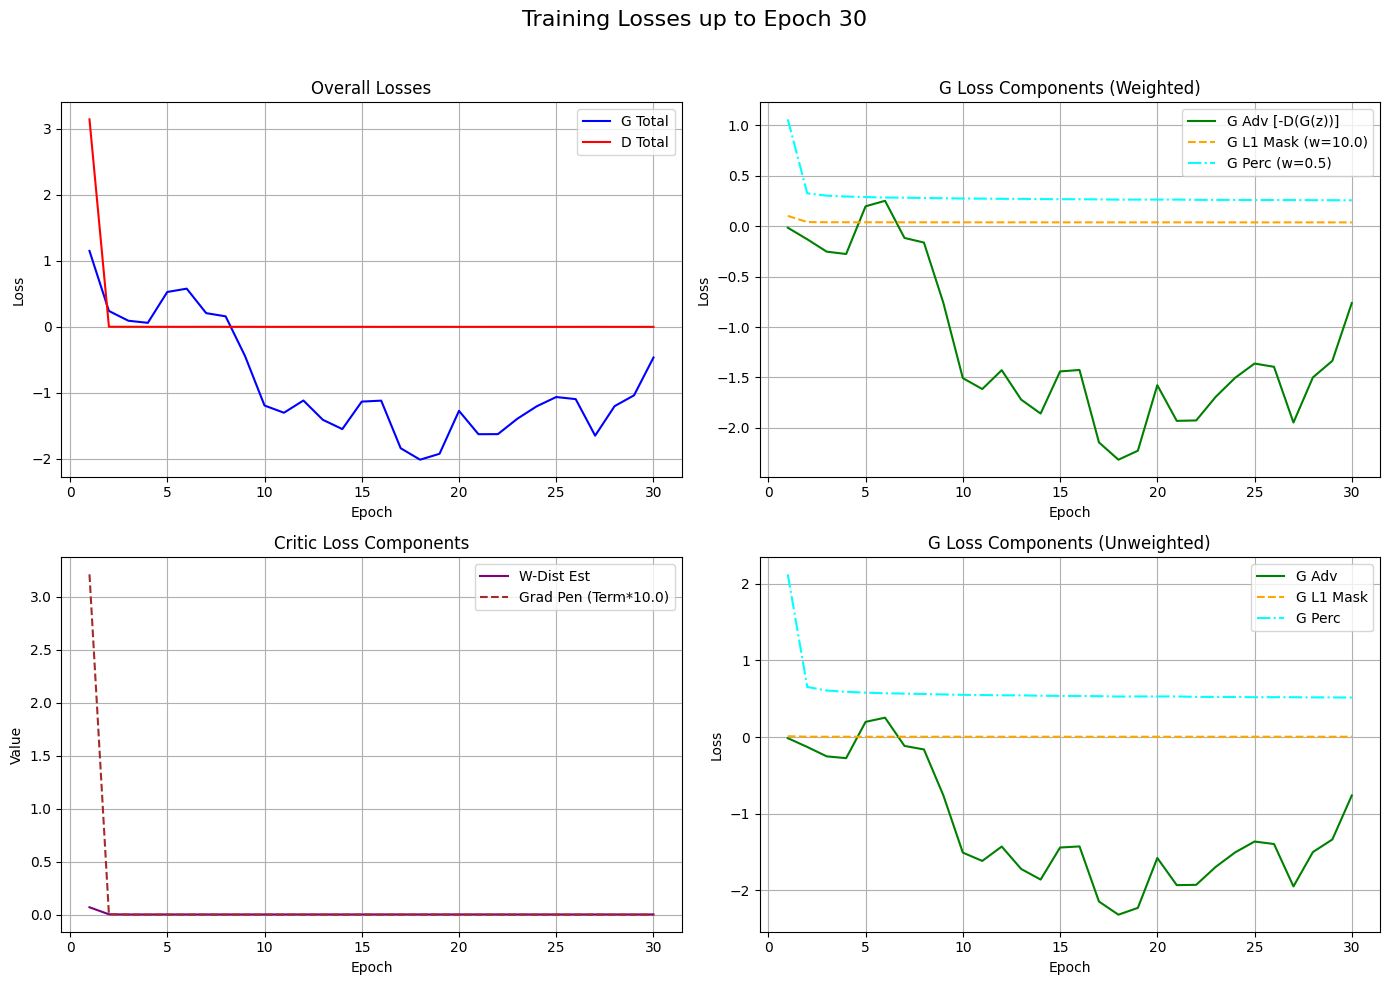


--- Evaluating on QuickDraw Samples (Seen Training Distribution) ---
QuickDraw download check/run to ./data/quickdraw_eval...
All needed QuickDraw files already exist.
Loading QuickDraw dataset (Seen/All samples)...


Loading 'cat' (Skip=0): 0it [00:00, ?it/s]

Loading 'dog' (Skip=0): 0it [00:00, ?it/s]

Loading 'house' (Skip=0): 0it [00:00, ?it/s]

Loading 'tree' (Skip=0): 0it [00:00, ?it/s]

Loading 'bicycle' (Skip=0): 0it [00:00, ?it/s]

Loading 'car' (Skip=0): 0it [00:00, ?it/s]

Loading 'face' (Skip=0): 0it [00:00, ?it/s]

Loading 'flower' (Skip=0): 0it [00:00, ?it/s]

QuickDraw Seen/All dataset loaded with 1600 samples.


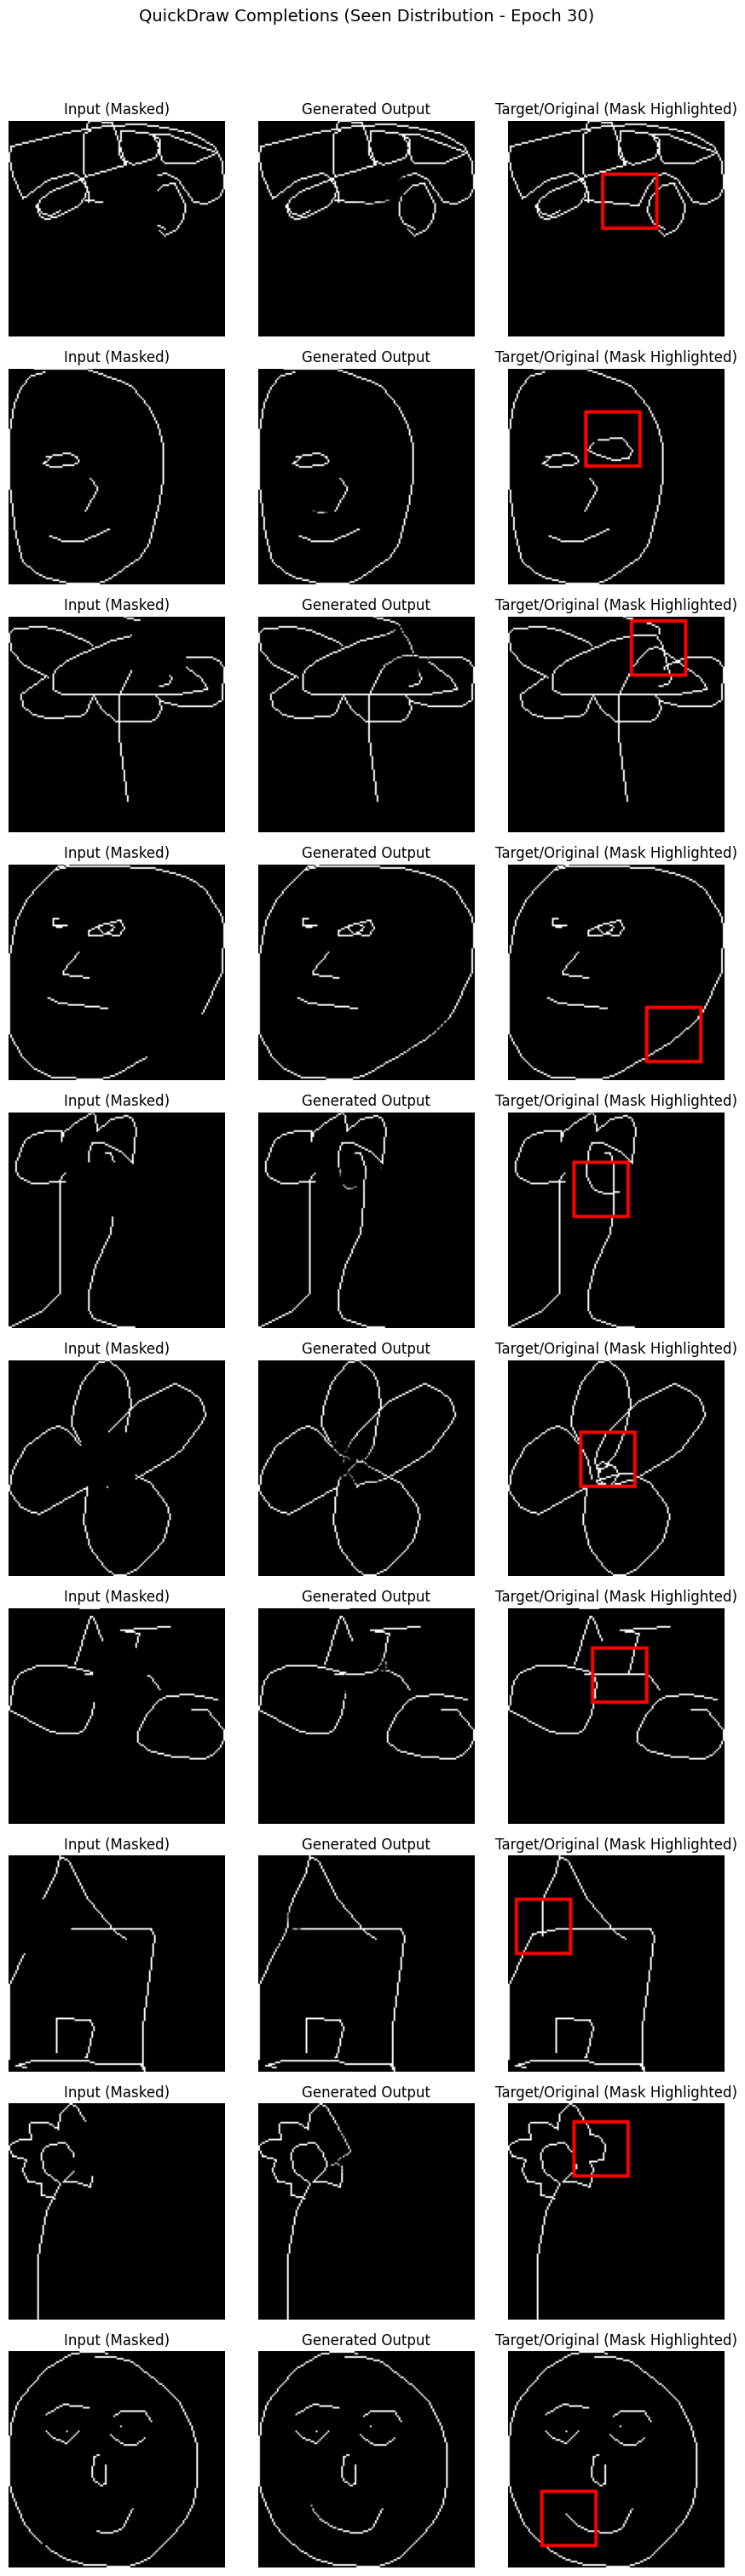

Calculating metrics for QuickDraw (Seen)...


Metrics on QuickDraw (Seen):   0%|          | 0/50 [00:00<?, ?it/s]

Metrics for QuickDraw (Seen) (1600 samples / 50 batches):
  Average Masked L1 (per pixel): 0.063701
  Average LPIPS: 0.0250

--- Evaluating on QuickDraw Samples (Unseen Training Distribution) ---
Loading QuickDraw dataset (Unseen samples)...


Loading 'cat' (Skip=5000): 0it [00:00, ?it/s]

Loading 'dog' (Skip=5000): 0it [00:00, ?it/s]

Loading 'house' (Skip=5000): 0it [00:00, ?it/s]

Loading 'tree' (Skip=5000): 0it [00:00, ?it/s]

Loading 'bicycle' (Skip=5000): 0it [00:00, ?it/s]

Loading 'car' (Skip=5000): 0it [00:00, ?it/s]

Loading 'face' (Skip=5000): 0it [00:00, ?it/s]

Loading 'flower' (Skip=5000): 0it [00:00, ?it/s]

QuickDraw Unseen dataset loaded with 1600 samples.


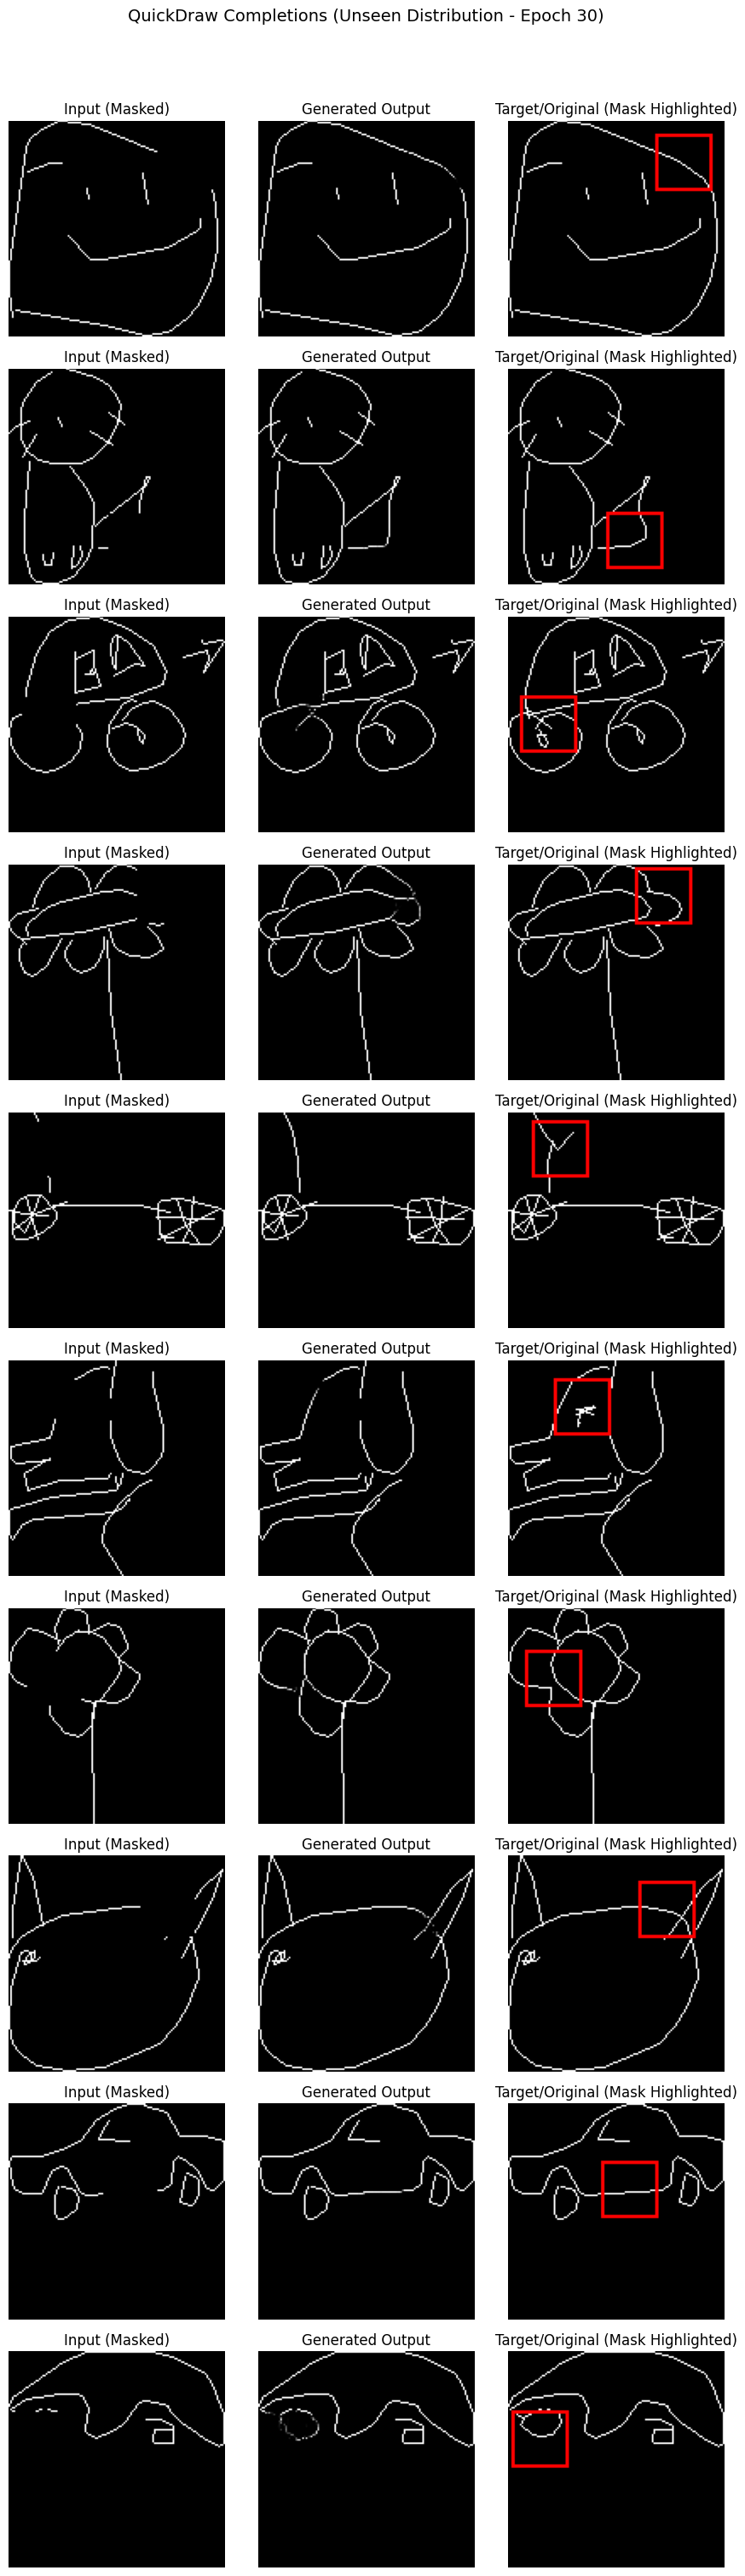

Calculating metrics for QuickDraw (Unseen)...


Metrics on QuickDraw (Unseen):   0%|          | 0/50 [00:00<?, ?it/s]

Metrics for QuickDraw (Unseen) (1600 samples / 50 batches):
  Average Masked L1 (per pixel): 0.064050
  Average LPIPS: 0.0252

--- Evaluating on ImageNet-Sketch Samples (Generalization Test) ---
Loading Hugging Face dataset: imagenet_sketch...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/78.7k [00:00<?, ?B/s]

imagenet_sketch.py:   0%|          | 0.00/3.25k [00:00<?, ?B/s]

classes.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

ImageNet-Sketch.zip:   0%|          | 0.00/7.59G [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50889 [00:00<?, ? examples/s]

Selected 500 samples for ImageNet processing.
Calculating metrics on up to 500 ImageNet samples...
Calculating metrics for ImageNet-Sketch...


Metrics on ImageNet-Sketch:   0%|          | 0/16 [00:00<?, ?it/s]


Debug Info for ImageNet-Sketch Masked L1:
  Raw L1 Sums (first 10 batches): [6378.767578125, 5540.10205078125, 7319.453125, 8176.21142578125, 6806.572265625, 6212.1669921875, 5487.37890625, 8138.6826171875, 6108.908203125, 5599.36767578125]
  Mask Pixel Counts (first 10 batches): [32768.0, 32768.0, 32768.0, 32768.0, 32768.0, 32768.0, 32768.0, 32768.0, 32768.0, 32768.0]
  Number batches non-zero L1 (>1e-9): 16/16
  Avg non-zero L1 sum: 6347.9921
Metrics for ImageNet-Sketch (500 samples / 16 batches):
  Average Masked L1 (per pixel): 0.196257
  Average LPIPS: 0.2605

Generating 8 ImageNet-Sketch samples for visualization...


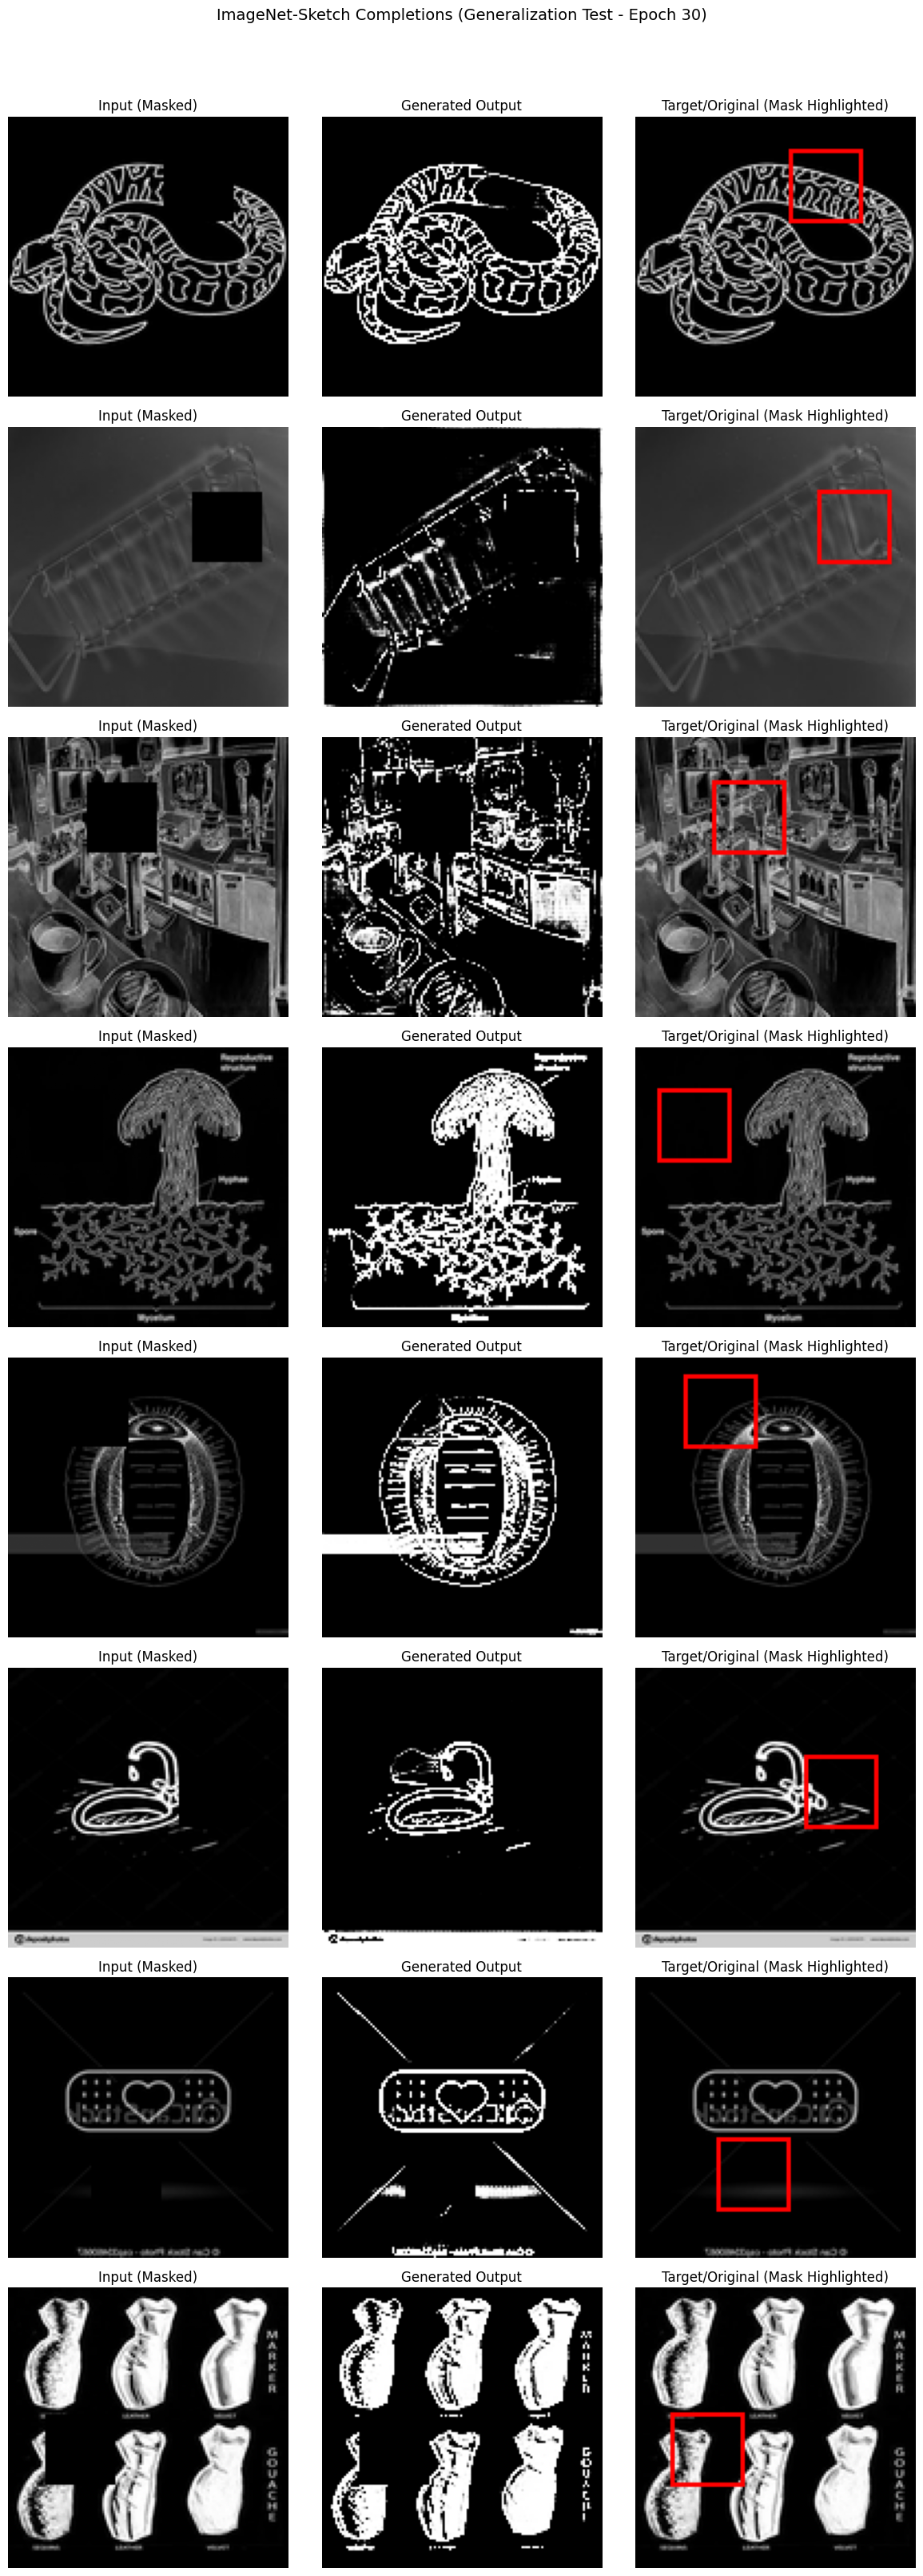


--- Processing Custom Sketches (if available) ---

--- Evaluating on Custom Sketches ---
Created './custom_sketches' directory. Please add your sketches there and run again.

QUANTITATIVE METRICS SUMMARY
Using Generator from Checkpoint: checkpoint_epoch_030.pth (Epoch 30)

Results for QD_Seen:
  Masked L1 (Avg per Pixel): 0.063701
  LPIPS (Avg per Image):     0.0250

Results for QD_Unseen:
  Masked L1 (Avg per Pixel): 0.064050
  LPIPS (Avg per Image):     0.0252

Results for INet_Sketch:
  Masked L1 (Avg per Pixel): 0.196257
  LPIPS (Avg per Image):     0.2605
EVALUATION COMPLETE


In [8]:
#### SECTION 8: EXECUTE EVALUATION ####

if __name__ == '__main__':
    run_comprehensive_evaluation()

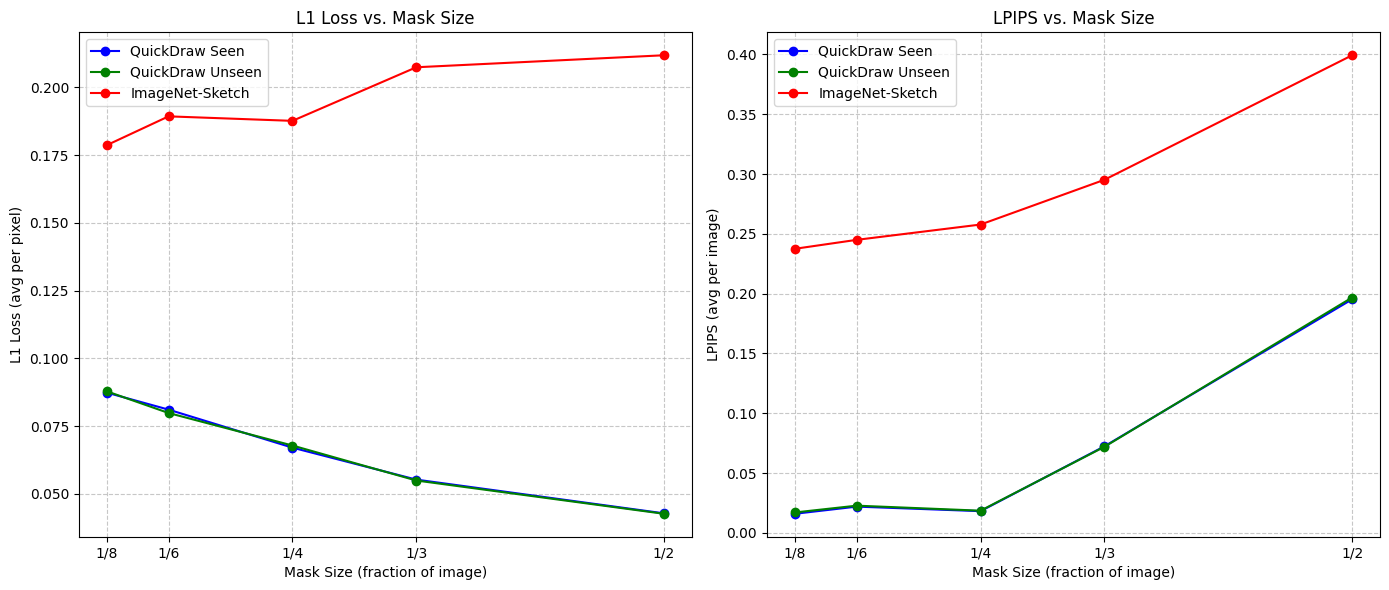

In [ ]:
# after trying various mask sizes, I gathered the quantitative evaluation metrics
# of each and am using them to make the plots below

# Mask sizes (as fractions of image)
mask_sizes = [1/8, 1/6, 1/4, 1/3, 1/2]
x_labels = ["1/8", "1/6", "1/4", "1/3", "1/2"]

l1_qd_seen = [0.087384, 0.081102, 0.067077, 0.055286, 0.042843]
l1_qd_unseen = [0.087879, 0.079854, 0.067863, 0.054958, 0.042677]
l1_inet = [0.178625, 0.189281, 0.187621, 0.207389, 0.211817]

lpips_qd_seen = [0.0160, 0.0220, 0.0182, 0.0724, 0.1953]
lpips_qd_unseen = [0.0171, 0.0228, 0.0186, 0.0720, 0.1968]
lpips_inet = [0.2375, 0.2450, 0.2578, 0.2952, 0.3993]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot L1 Loss
ax1.plot(mask_sizes, l1_qd_seen, 'b-o', label='QuickDraw Seen')
ax1.plot(mask_sizes, l1_qd_unseen, 'g-o', label='QuickDraw Unseen')
ax1.plot(mask_sizes, l1_inet, 'r-o', label='ImageNet-Sketch')
ax1.set_title('L1 Loss vs. Mask Size')
ax1.set_xlabel('Mask Size (fraction of image)')
ax1.set_ylabel('L1 Loss (avg per pixel)')
ax1.set_xticks(mask_sizes)
ax1.set_xticklabels(x_labels)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()

# Plot LPIPS
ax2.plot(mask_sizes, lpips_qd_seen, 'b-o', label='QuickDraw Seen')
ax2.plot(mask_sizes, lpips_qd_unseen, 'g-o', label='QuickDraw Unseen')
ax2.plot(mask_sizes, lpips_inet, 'r-o', label='ImageNet-Sketch')
ax2.set_title('LPIPS vs. Mask Size')
ax2.set_xlabel('Mask Size (fraction of image)')
ax2.set_ylabel('LPIPS (avg per image)')
ax2.set_xticks(mask_sizes)
ax2.set_xticklabels(x_labels)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()

plt.tight_layout()
plt.savefig('metrics_vs_mask_size.png', dpi=300)
plt.show()

In [ ]:
def inspect_checkpoint(checkpoint_path):
    """
    Load and inspect the contents of the PyTorch checkpoint file
    """
    if not os.path.exists(checkpoint_path):
        print(f"ERROR: File not found: {checkpoint_path}")
        return

    try:
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        print(f"Successfully loaded checkpoint: {checkpoint_path}")

        print("\nCheckpoint contains the following keys:")
        for i, key in enumerate(checkpoint.keys()):
            print(f"{i+1}. {key}")

        print("\nDetailed inspection of each component:")
        for key, value in checkpoint.items():
            print(f"\n--- {key} ---")

            if isinstance(value, dict):
                print(f"Type: Dictionary with {len(value)} keys")
                tensor_count = sum(1 for v in value.values() if isinstance(v, torch.Tensor))
                print(f"Contains {tensor_count} tensor(s)")

                # Print some example tensor shapes
                count = 0
                for subkey, subval in value.items():
                    if isinstance(subval, torch.Tensor):
                        shape_str = str(list(subval.shape))
                        print(f"  - {subkey}: tensor {shape_str}")

                        # Show statistics for a few tensors
                        if count < 100:
                            try:
                                print(f"    → min: {subval.min().item():.6f}, max: {subval.max().item():.6f}, mean: {subval.mean().item():.6f}")
                            except:
                                print("    → Unable to calculate statistics")
                        count += 1

                if count > 100:
                    print(f"  ... and {count-3} more tensors")

            elif isinstance(value, torch.Tensor):
                print(f"Type: Tensor of shape {list(value.shape)}")
                try:
                    print(f"Statistics: min={value.min().item():.6f}, max={value.max().item():.6f}, mean={value.mean().item():.6f}")
                except:
                    print("Unable to calculate statistics")

            elif isinstance(value, (int, float, str, bool)):
                print(f"Type: {type(value).__name__}")
                print(f"Value: {value}")

            elif isinstance(value, list):
                print(f"Type: List of length {len(value)}")
                if len(value) > 0:
                    print(f"First few elements: {value[:min(3, len(value))]}")

            else:
                print(f"Type: {type(value).__name__}")

    except Exception as e:
        print(f"ERROR examining checkpoint: {str(e)}")

checkpoint_path = "checkpoint_epoch_010.pth"
inspect_checkpoint(checkpoint_path)
print("="*200)
print("="*200)
print("="*200)
checkpoint_path = "checkpoint_epoch_030_old.pth"
inspect_checkpoint(checkpoint_path)
print("="*200)
print("="*200)
print("="*200)
checkpoint_path = "checkpoint_epoch_025.pth"
inspect_checkpoint(checkpoint_path)
print("="*200)
print("="*200)
print("="*200)
checkpoint_path = "checkpoint_epoch_005.pth"
inspect_checkpoint(checkpoint_path)
print("="*200)
print("="*200)
print("="*200)
checkpoint_path = "checkpoint_epoch_030.pth"
inspect_checkpoint(checkpoint_path)

Successfully loaded checkpoint: checkpoint_epoch_010.pth

Checkpoint contains the following keys:
1. epoch
2. generator_state_dict
3. discriminator_state_dict
4. g_optimizer_state_dict
5. d_optimizer_state_dict
6. g_losses
7. d_losses
8. g_adv_losses
9. g_l1_masked_losses
10. g_l1_unmasked_losses
11. g_perceptual_losses
12. d_real_losses
13. d_fake_losses

Detailed inspection of each component:

--- epoch ---
Type: int
Value: 9

--- generator_state_dict ---
Type: Dictionary with 64 keys
Contains 64 tensor(s)
  - enc1.0.weight: tensor [48, 1, 3, 3]
    → min: -0.366761, max: 0.348688, mean: -0.022739
  - enc1.1.weight: tensor [48]
    → min: 0.954865, max: 1.075137, mean: 1.004535
  - enc1.1.bias: tensor [48]
    → min: -0.051903, max: 0.044260, mean: -0.005298
  - enc1.3.weight: tensor [48, 48, 3, 3]
    → min: -0.106022, max: 0.118947, mean: -0.001080
  - enc1.4.weight: tensor [48]
    → min: 0.926045, max: 1.075746, mean: 0.988431
  - enc1.4.bias: tensor [48]
    → min: -0.067286, ma

In [ ]:
# map checkpoint files to model types
checkpoints = {
    "checkpoint_epoch_010.pth": "LSGAN (Epoch 10)",
    "checkpoint_epoch_030_old.pth": "LSGAN (Epoch 30)",
    "checkpoint_epoch_005.pth": "WGAN-GP (Epoch 5)",
    "checkpoint_epoch_025.pth": "WGAN-GP (Epoch 25)",
    "checkpoint_epoch_030.pth": "WGAN-GP+Attention (Epoch 30)"
}

checkpoint_data = {}

# Load all checkpoints
for ckpt_file, model_name in checkpoints.items():
    try:
        checkpoint = torch.load(ckpt_file, map_location='cpu')
        checkpoint_data[model_name] = checkpoint
        print(f"Successfully loaded {model_name}")
    except Exception as e:
        print(f"Error loading {ckpt_file}: {e}")

# ==============================================
# 1. Loss Landscape Analysis
# ==============================================
def plot_loss_curves():
    plt.figure(figsize=(20, 16))

    colors = {
        "LSGAN": "blue",
        "WGAN-GP": "green",
        "WGAN-GP+Attention": "red"
    }

    loss_types = {
        "Generator Loss": "g_losses",
        "Discriminator Loss": "d_losses",
        "Generator Adversarial Loss": "g_adv_losses",
        "Masked L1 Loss": "g_l1_masked_losses",
        "Perceptual Loss": "g_perceptual_losses"
    }

    wgan_loss_types = {
        "Gradient Penalty Loss": "d_gp_losses",
        "Wasserstein Distance": "wasserstein_distances"
    }

    # Create subplot for each loss type
    for i, (title, loss_key) in enumerate(loss_types.items()):
        plt.subplot(3, 3, i+1)

        for model_name, data in checkpoint_data.items():
            if loss_key not in data:
                continue

            if "LSGAN" in model_name:
                base_color = colors["LSGAN"]
                linestyle = "-" if "30" in model_name else "--"
            elif "Attention" in model_name:
                base_color = colors["WGAN-GP+Attention"]
                linestyle = "-"
            else:
                base_color = colors["WGAN-GP"]
                linestyle = "-" if "25" in model_name else "--"

            losses = data[loss_key]
            epochs = range(1, len(losses) + 1)
            plt.plot(epochs, losses, label=model_name, color=base_color, linestyle=linestyle)

        plt.title(title)
        plt.xlabel("Epoch")
        plt.ylabel("Loss Value")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()

    # Plot WGAN-specific losses
    for i, (title, loss_key) in enumerate(wgan_loss_types.items()):
        plt.subplot(3, 3, len(loss_types) + i + 1)

        for model_name, data in checkpoint_data.items():
            if loss_key not in data:
                continue

            if "Attention" in model_name:
                base_color = colors["WGAN-GP+Attention"]
                linestyle = "-"
            else:
                base_color = colors["WGAN-GP"]
                linestyle = "-" if "25" in model_name else "--"

            losses = data[loss_key]
            epochs = range(1, len(losses) + 1)
            plt.plot(epochs, losses, label=model_name, color=base_color, linestyle=linestyle)

        plt.title(title)
        plt.xlabel("Epoch")
        plt.ylabel("Loss Value")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()

    plt.tight_layout()
    plt.savefig("loss_landscape_analysis.png", dpi=300)
    plt.close()
    print("Loss landscape analysis saved to 'loss_landscape_analysis.png'")

# ==============================================
# 2. Comparison of Key Metrics
# ==============================================
def compare_key_metrics():
    metrics = [
        ("Final Generator Loss", "g_losses"),
        ("Final Masked L1 Loss", "g_l1_masked_losses"),
        ("Final Perceptual Loss", "g_perceptual_losses"),
        ("Final Adversarial Loss", "g_adv_losses")
    ]

    metrics_df = pd.DataFrame(index=[model_name for model_name in checkpoint_data.keys()])

    # Extract the final values for each metric
    for title, key in metrics:
        final_values = []
        for model_name, data in checkpoint_data.items():
            if key in data and len(data[key]) > 0:
                final_values.append(data[key][-1])
            else:
                final_values.append(None)

        metrics_df[title] = final_values

    # Plot bar charts for each metric
    plt.figure(figsize=(18, 15))

    for i, (title, _) in enumerate(metrics):
        plt.subplot(2, 2, i+1)

        bar_colors = []
        for model_name in metrics_df.index:
            if "LSGAN" in model_name:
                bar_colors.append("blue")
            elif "Attention" in model_name:
                bar_colors.append("red")
            else:
                bar_colors.append("green")

        metrics_df[title].plot(kind='bar', color=bar_colors)
        plt.title(title)
        plt.ylabel("Value")
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig("key_metrics_comparison.png", dpi=300)
    plt.close()

    print("\nKey Metrics Comparison:")
    print(metrics_df.to_string())
    print("\nMetrics comparison saved to 'key_metrics_comparison.png'")

# ==============================================
# 3. Architecture Comparison (Text)
# ==============================================
def summarize_architecture():
    architecture_summaries = {}

    for model_name, data in checkpoint_data.items():
        summary = {"generator": {}, "discriminator": {}}

        # Analyze generator
        if "generator_state_dict" in data:
            gen_dict = data["generator_state_dict"]

            encoder_blocks = []
            decoder_blocks = []
            bottleneck_info = {}
            attention_details = {}

            encoder_keys = [k for k in gen_dict.keys() if k.startswith("enc")]
            decoder_keys = [k for k in gen_dict.keys() if k.startswith("dec")]
            bottleneck_keys = [k for k in gen_dict.keys() if "bottleneck" in k]
            upconv_keys = [k for k in gen_dict.keys() if "upconv" in k]

            # Extract encoder block details for the 4 blocks
            for i in range(1, 5):
                block_keys = [k for k in encoder_keys if f"enc{i}" in k]
                if block_keys:
                    conv1_shape = None
                    conv2_shape = None
                    norm1_params = None
                    norm2_params = None

                    for key in block_keys:
                        if f"enc{i}.0.weight" in key:
                            conv1_shape = gen_dict[key].shape
                        elif f"enc{i}.3.weight" in key:
                            conv2_shape = gen_dict[key].shape
                        elif f"enc{i}.1.weight" in key:
                            norm1_params = (gen_dict[key].shape, gen_dict[key].mean().item())
                        elif f"enc{i}.4.weight" in key:
                            norm2_params = (gen_dict[key].shape, gen_dict[key].mean().item())

                    encoder_blocks.append({
                        "block": i,
                        "conv1_shape": conv1_shape,
                        "conv2_shape": conv2_shape,
                        "norm1_params": norm1_params,
                        "norm2_params": norm2_params,
                        "has_residual": False
                    })

            # Extract bottleneck details
            bottleneck_conv_shapes = []
            has_attention = False
            attention_shape = None

            for key in bottleneck_keys:
                if ".weight" in key and len(gen_dict[key].shape) > 1:
                    if "attn" in key:
                        has_attention = True
                        attention_shape = gen_dict[key].shape
                    else:
                        bottleneck_conv_shapes.append(gen_dict[key].shape)

            bottleneck_info = {
                "conv_shapes": bottleneck_conv_shapes,
                "has_attention": has_attention,
                "attention_shape": attention_shape,
                "attention_mechanism": "Spatial attention in bottleneck" if has_attention else None
            }

            # Extract decoder block details for the 4 blocks
            for i in range(1, 5):
                block_keys = [k for k in decoder_keys if f"dec{i}" in k]
                upconv_shape = None

                for key in upconv_keys:
                    if f"upconv{i}" in key and ".weight" in key:
                        upconv_shape = gen_dict[key].shape

                if block_keys:
                    conv1_shape = None
                    conv2_shape = None
                    norm1_params = None
                    norm2_params = None

                    for key in block_keys:
                        if f"dec{i}.0.weight" in key:
                            conv1_shape = gen_dict[key].shape
                        elif f"dec{i}.3.weight" in key:
                            conv2_shape = gen_dict[key].shape
                        elif f"dec{i}.1.weight" in key:
                            norm1_params = (gen_dict[key].shape, gen_dict[key].mean().item())
                        elif f"dec{i}.4.weight" in key:
                            norm2_params = (gen_dict[key].shape, gen_dict[key].mean().item())

                    decoder_blocks.append({
                        "block": i,
                        "upconv_shape": upconv_shape,
                        "conv1_shape": conv1_shape,
                        "conv2_shape": conv2_shape,
                        "norm1_params": norm1_params,
                        "norm2_params": norm2_params,
                        "has_skip_connection": True
                    })

            input_channels = None
            output_channels = None
            for key in gen_dict.keys():
                if "enc1.0.weight" in key:
                    input_channels = gen_dict[key].shape[1]
                if "final_conv.weight" in key:
                    output_channels = gen_dict[key].shape[0]

            # Final details
            final_conv_shape = None
            for key in gen_dict.keys():
                if "final_conv.weight" in key:
                    final_conv_shape = gen_dict[key].shape

            summary["generator"] = {
                "architecture_type": "U-Net with skip connections",
                "encoder_stages": len(encoder_blocks),
                "decoder_stages": len(decoder_blocks),
                "encoder_blocks": encoder_blocks,
                "decoder_blocks": decoder_blocks,
                "bottleneck": bottleneck_info,
                "input_channels": input_channels,
                "output_channels": output_channels,
                "final_conv": final_conv_shape,
                "activation": "Likely ReLU in hidden layers, possibly Tanh or Sigmoid for output",
                "normalization": "Batch Normalization in each encoder/decoder block",
                "has_attention": has_attention,
                "attention_details": "Spatial attention at bottleneck" if has_attention else None
            }

        # Analyze discriminator
        if "discriminator_state_dict" in data:
            disc_dict = data["discriminator_state_dict"]

            layer_weights = [k for k in disc_dict.keys() if ".weight" in k]
            layer_shapes = [(k, disc_dict[k].shape) for k in layer_weights]

            is_wgan = "wasserstein_distances" in data
            has_spectral_norm = len(disc_dict) == 10  # WGAN with SN has 10 keys

            first_layer = None
            last_layer = None

            for k, shape in layer_shapes:
                if "model.0.weight" in k:
                    first_layer = shape
                if "model.11.weight" in k:
                    last_layer = shape

            # PatchGAN details
            patch_size = None
            if first_layer is not None and last_layer is not None:
                kernel_size = first_layer[2]
                num_layers = len(layer_shapes)
                # PatchGAN simplified receptive field formula
                patch_size = (kernel_size - 1) * (2 ** (num_layers - 1)) + 1

            summary["discriminator"] = {
                "architecture_type": "PatchGAN Discriminator" if not is_wgan else "WGAN Critic",
                "num_layers": len(layer_shapes),
                "layer_config": layer_shapes,
                "first_layer": first_layer,
                "last_layer": last_layer,
                "output_type": "1-channel probability map" if not is_wgan else "1-channel critic score",
                "has_spectral_norm": has_spectral_norm,
                "estimated_patch_size": patch_size,
                "stride": "Likely 2 for downsampling layers",
                "activation": "Leaky ReLU (likely slope=0.2)" if not is_wgan else "Leaky ReLU with no final activation",
                "normalization": "Instance Norm" if not is_wgan else "Spectral Normalization"
            }

        # Extract loss function details
        loss_types = []
        for key in data.keys():
            if key.endswith("losses"):
                loss_types.append(key)

        summary["loss_configuration"] = loss_types

        architecture_summaries[model_name] = summary

    print("\nDetailed Architecture Summaries:")
    for model_name, summary in architecture_summaries.items():
        print(f"\n{'-'*80}\n{model_name}:\n{'-'*80}")

        # Generator summary
        print("\n GENERATOR:")
        gen = summary["generator"]

        print(f"  Architecture Type: {gen.get('architecture_type', 'Unknown')}")
        print(f"  Input Channels: {gen.get('input_channels', 'unknown')}, Output Channels: {gen.get('output_channels', 'unknown')}")
        print(f"  Structure: {gen.get('encoder_stages', 'unknown')} encoder stages and {gen.get('decoder_stages', 'unknown')} decoder stages")

        if gen.get("has_attention", False):
            print(f"  Attention Mechanism: {gen.get('attention_details', 'Present but details unknown')}")
            if gen.get("bottleneck", {}).get("attention_shape") is not None:
                print(f"    - Attention shape: {gen.get('bottleneck', {}).get('attention_shape')}")

        print("\n  Encoder Structure:")
        for block in gen.get("encoder_blocks", []):
            print(f"    - Block {block['block']}: {block.get('conv1_shape', 'unknown')} → {block.get('conv2_shape', 'unknown')}")

        print("\n  Bottleneck:")
        bottleneck = gen.get("bottleneck", {})
        if bottleneck.get("conv_shapes"):
            for i, shape in enumerate(bottleneck.get("conv_shapes", [])):
                print(f"    - Conv {i+1}: {shape}")

        print("\n  Decoder Structure:")
        for block in gen.get("decoder_blocks", []):
            print(f"    - Block {block['block']}: Upconv {block.get('upconv_shape', 'unknown')} → {block.get('conv1_shape', 'unknown')} → {block.get('conv2_shape', 'unknown')}")
            print(f"      Skip connection: {'Yes' if block.get('has_skip_connection', False) else 'No'}")

        print(f"  Final Conv: {gen.get('final_conv', 'unknown')}")
        print(f"  Activation: {gen.get('activation', 'unknown')}")
        print(f"  Normalization: {gen.get('normalization', 'unknown')}")

        # Discriminator summary
        print("\n DISCRIMINATOR/CRITIC:")
        disc = summary["discriminator"]

        print(f"  Architecture Type: {disc.get('architecture_type', 'Unknown')}")
        print(f"  Number of Layers: {disc.get('num_layers', 'unknown')}")
        print(f"  Input Layer Shape: {disc.get('first_layer', 'unknown')}")
        print(f"  Output Layer Shape: {disc.get('last_layer', 'unknown')}")
        print(f"  Output Type: {disc.get('output_type', 'unknown')}")

        if disc.get('has_spectral_norm', False):
            print("  Using Spectral Normalization for stability")

        print(f"  Estimated Receptive Field (Patch Size): {disc.get('estimated_patch_size', 'unknown')}")
        print(f"  Activation: {disc.get('activation', 'unknown')}")
        print(f"  Normalization: {disc.get('normalization', 'unknown')}")

        # Loss function details
        print("\n LOSS CONFIGURATION:")
        for loss_type in summary.get("loss_configuration", []):
            print(f"  - {loss_type}")

    return architecture_summaries

if checkpoint_data:
    plot_loss_curves()
    compare_key_metrics()
    architecture_summaries = summarize_architecture()
else:
    print("No checkpoint data loaded. Please check file paths.")

Successfully loaded LSGAN (Epoch 10)
Successfully loaded LSGAN (Epoch 30)
Successfully loaded WGAN-GP (Epoch 5)
Successfully loaded WGAN-GP (Epoch 25)
Successfully loaded WGAN-GP+Attention (Epoch 30)
Loss landscape analysis saved to 'loss_landscape_analysis.png'

Key Metrics Comparison:
                              Final Generator Loss  Final Masked L1 Loss  Final Perceptual Loss  Final Adversarial Loss
LSGAN (Epoch 10)                          0.433113              0.003583               0.913443                0.595100
LSGAN (Epoch 30)                          0.469055              0.003515               0.924201                0.712334
WGAN-GP (Epoch 5)                         1.571331              0.003919               0.578969                1.242652
WGAN-GP (Epoch 25)                        7.365495              0.003842               0.523897                7.065122
WGAN-GP+Attention (Epoch 30)             -0.466443              0.003815               0.514207               -0